In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import minmax_scale
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import warnings
import sklearn
warnings.filterwarnings('ignore')

In [30]:
# Introduce the test and train dataset
test = pd.read_csv("test.csv")
test_shape = test.shape

train = pd.read_csv('train.csv')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


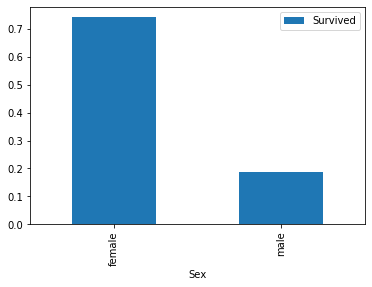

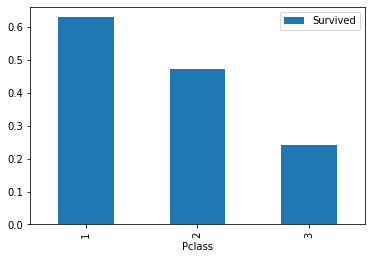

In [31]:
# Preliminary exploration of survival rate
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()
pclass_pivot = train.pivot_table(index = 'Pclass', values = 'Survived')
pclass_pivot.plot.bar()
plt.show()

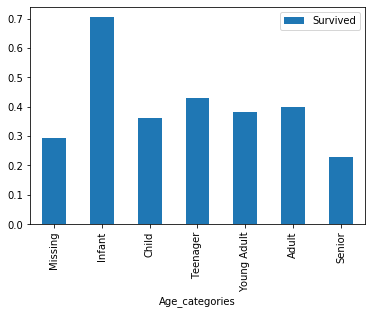

In [32]:
# Turn age into categories
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

In [33]:
# Create dummies
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")
# Using categories for age, we see that infants are more likely to survive.

In [34]:
#Logistic regression
holdout = test # from now on we will refer to this dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size = 0.2, random_state = 0)

In [35]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


In [36]:
# Cross-validation to avoid overfitting
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy = np.mean(scores)
print(accuracy)

0.8024670865963002


In [37]:
# Model selection and tuning
train = pd.read_csv('train_modified.csv')
holdout = pd.read_csv('holdout_modified.csv')

In [38]:
# Logistic regression accuracy score
all_X = train.drop(['Survived','PassengerId'],axis=1)
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy_lr = scores.mean()

print(accuracy_lr)

0.823891442515038


In [39]:
# K-nearest neighbours accuracy score
knn = KNeighborsClassifier(n_neighbors = 1)
scores = cross_val_score(knn, all_X, all_y, cv = 10)
accuracy_knn = scores.mean()

print(accuracy_knn)

0.7857382816933379


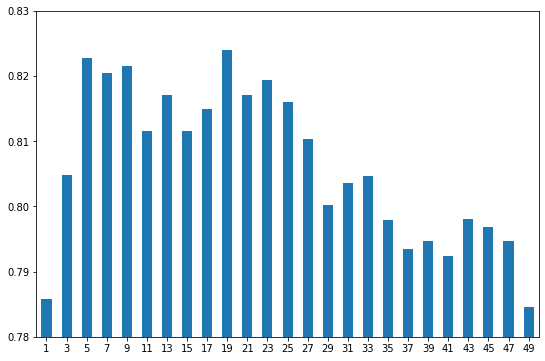

In [40]:
# Hyperparameter optimization on k-nearest neighbours
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = dict()

for k in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, all_X, all_y, cv = 10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn
    
plot_dict(knn_scores)

In [41]:
# Use grid search for model selection
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = hyperparameters, cv = 10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.8282828282828283


In [42]:
# Random forest classifier score
clf = RandomForestClassifier(random_state = 1)
scores = cross_val_score(clf, all_X, all_y, cv = 10)
accuracy_rf = scores.mean()
print(accuracy_rf)

0.8070125411417546


In [27]:
clf = RandomForestClassifier(random_state = 1)

hyperparameters = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [5, 10],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [3, 5],
    'n_estimators': [6, 9]
}

grid = GridSearchCV(clf, param_grid = hyperparameters, cv = 10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
0.8428731762065096
